<a href="https://colab.research.google.com/github/nikishkaaa/Sales_Prediction_Time_Series/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction Store Sales with Time Series

## Problem Statement
Our goal is to predict next month's daily sales. Accordingly, we will conduct experiments to find the best model for this task.
We will use the Mean Absolute Percentage Error (MAPE) as our evaluation metric.

In [ ]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:0

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import scipy.stats as stats
from darts.utils.statistics import plot_residuals_analysis
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveSeasonal, NaiveDrift, XGBModel, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler

In [ ]:
data_raw = pd.read_csv('TimeSeries_data.csv')
data_raw['date'] = pd.to_datetime(data_raw['date'])

data = data_raw.copy()
data.set_index('date', inplace=True)
data.head(10)

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


## EDA



In [ ]:
daily_sales = data_raw.groupby('date', as_index=False)['sales'].sum()
item_daily_sales = data_raw.groupby(['item', 'date'], as_index=False)['sales'].sum()
store_item_sales = data_raw.groupby(['store', 'item'], as_index=False)['sales'].sum()
store_daily_sales = data_raw.groupby(['store', 'date'], as_index=False)['sales'].sum()

In [ ]:
fig1 = px.line(item_daily_sales, x='date', y='sales', color='item',
                title='Sales Dynamics by Item')
fig1.show()

In [ ]:
fig2 = px.bar(store_item_sales, x='store', y='sales', color='item',
               title='Sales by Store for Each Item',
               barmode='group')
fig2.show()

In [ ]:
fig3 = px.area(daily_sales, x='date', y='sales',
                title='Daily Sales in all stores')
fig3.show()

In [ ]:
fig4 = px.line(store_daily_sales, x='date', y='sales', color='store',
                title='Sales Dynamics by Store')
fig4.show()

In [ ]:
## store1 + item1
df = data[(data['item'] == 1) & (data['store'] == 1)]

In [ ]:
df.head(2)

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11

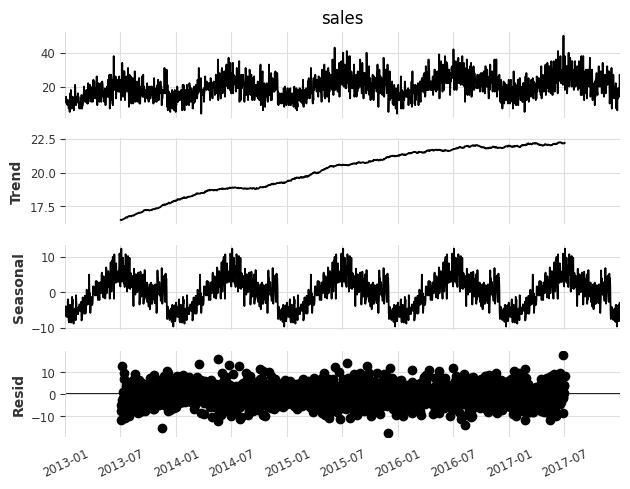

In [ ]:
df_additive = seasonal_decompose(df['sales'], model = 'additive', period=365)
df_additive.plot()
plt.xticks(rotation=25)
plt.show()

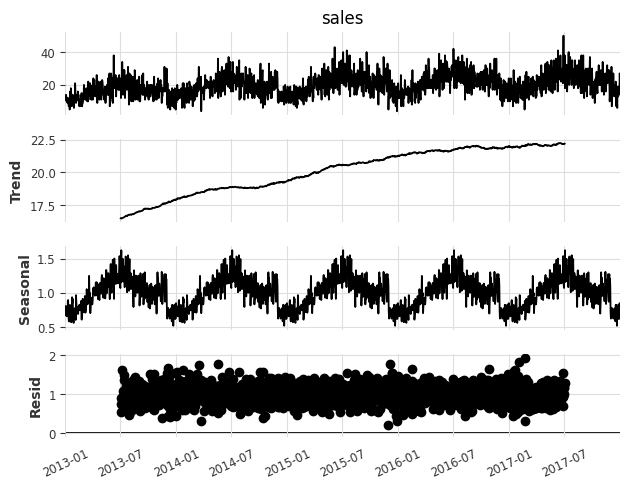

In [ ]:
df_multi = seasonal_decompose(df['sales'], model = 'multiplicative', period=365)
df_multi.plot()
plt.xticks(rotation=25)
plt.show()

Conclusion:

 - The sales chart shows that the series is quite variable, with consistent fluctuations throughout the entire period.
 - The time series has an upward trend. Sales exhibit seasonality.
 - The residuals represent noise or random variations that cannot be explained by the trend or seasonality.

## Residuals analysis

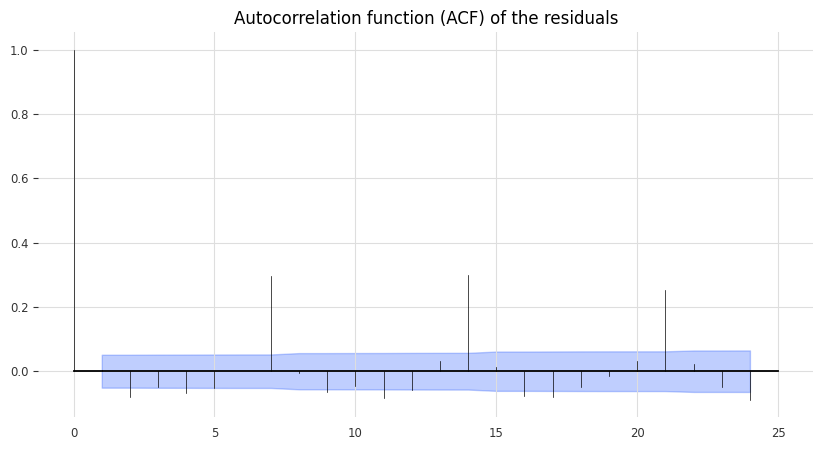

In [ ]:
residuals = df_additive.resid.dropna()
residuals_ts = TimeSeries.from_dataframe(pd.DataFrame(residuals))
plot_acf(residuals_ts)
plt.title('Autocorrelation function (ACF) of the residuals')
plt.show()

W-stats: 0.998730099016241, p-value: 0.3774649394825057


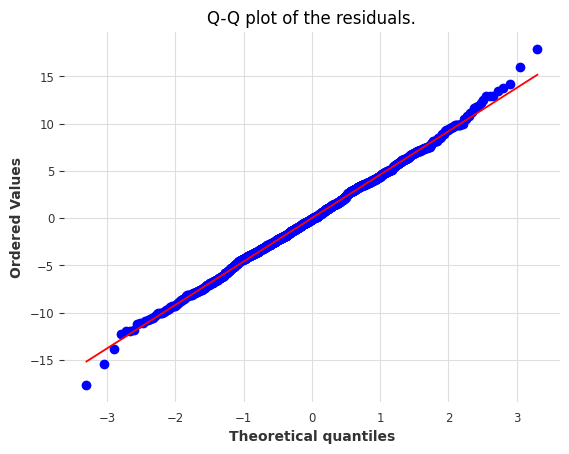

In [ ]:
##The Shapiro-Wilk test
stat, p_value = shapiro(df_additive.resid.dropna())
print(f'W-stats: {stat}, p-value: {p_value}')

# Q-Q plot for residuals
stats.probplot(df_additive.resid.dropna(), dist="norm", plot=plt)
plt.title('Q-Q plot of the residuals.')
plt.show()

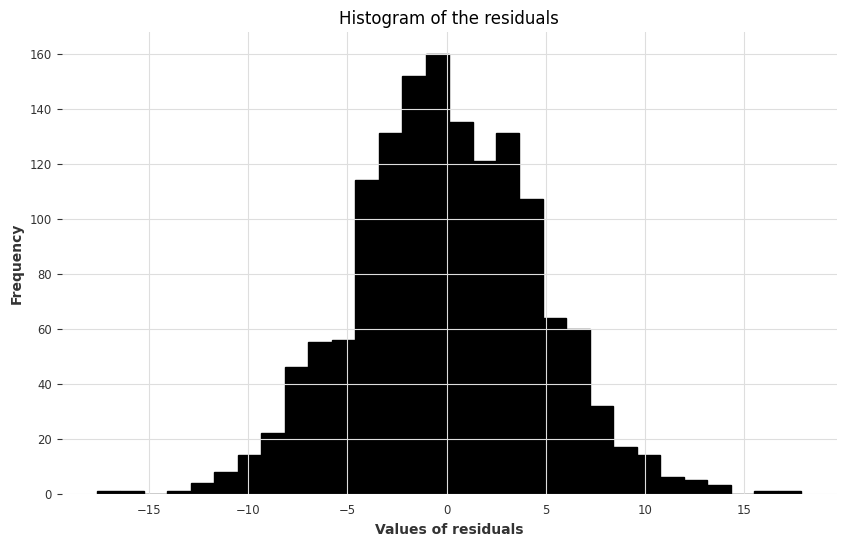

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_additive.resid.dropna(), bins=30, edgecolor='k')
plt.title('Histogram of the residuals')
plt.xlabel('Values of residuals')
plt.ylabel('Frequency')

plt.show()

Conclusion: From the autocorrelation function (ACF) plot, we observe that autocorrelation for some lags falls within the confidence interval, indicating a certain dependency in the residuals. However, other plots show that the residuals follow a normal distribution. Therefore, we can conclude that the additive model adequately describes the data.

## Models

In [ ]:
time_df = TimeSeries.from_dataframe(df, value_cols = 'sales')
time_df

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

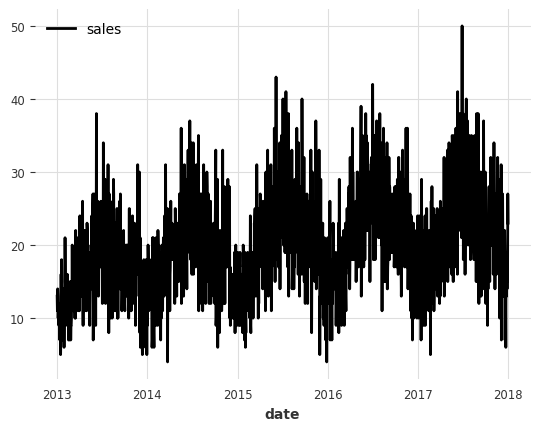

In [ ]:
time_df.plot()

<Axes: xlabel='date'>

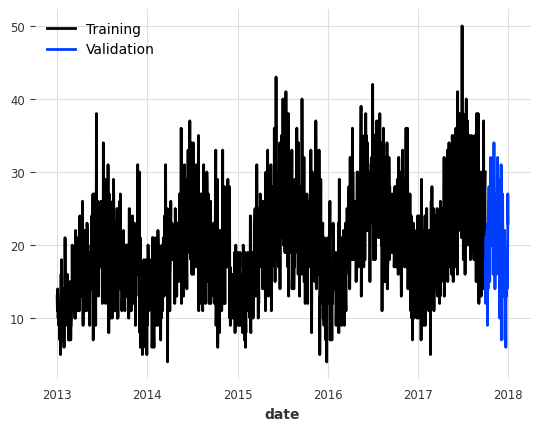

In [ ]:
train, val = time_df.split_before(pd.Timestamp("2017-10-01"))
train.plot(label = 'Training')
val.plot(label = 'Validation')

In [ ]:
time_df

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
df = df['sales']

<Figure size 1000x600 with 0 Axes>

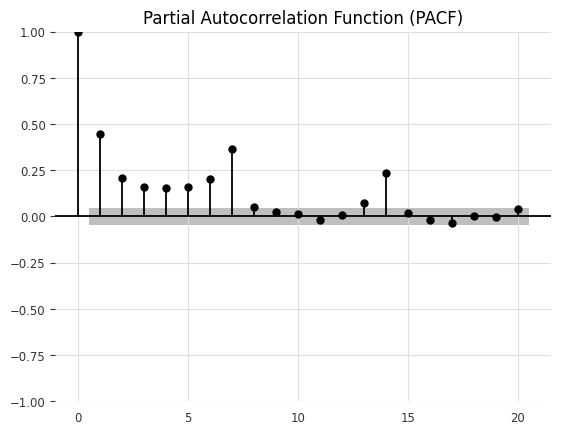

In [ ]:
#(PACF)
plt.figure(figsize=(10, 6))
plot_pacf(df, lags=20, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Conclusion: Significant values at the subsequent lags indicate that the correlation at these lags remains meaningful, even after accounting for the influence of intermediate lags.

#### Seasonality

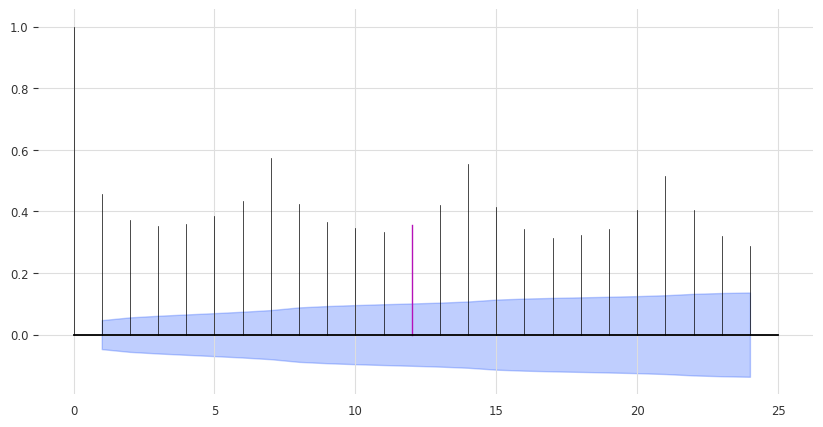

In [ ]:
plot_acf(train, m=12, alpha=0.05, max_lag=24)

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


In [ ]:
is_seasonal, period = check_seasonality(train, max_lag=365)

if is_seasonal:
    print(f"The series is seasonal with a period of {period}.")
else:
    print("Seasonality was not detected")

Ряд є сезонним з періодом 7.


## NaiveSeasonal

In [ ]:
def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")

def fit_eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    eval_forecast(model, val, forecast)

<Axes: xlabel='date'>

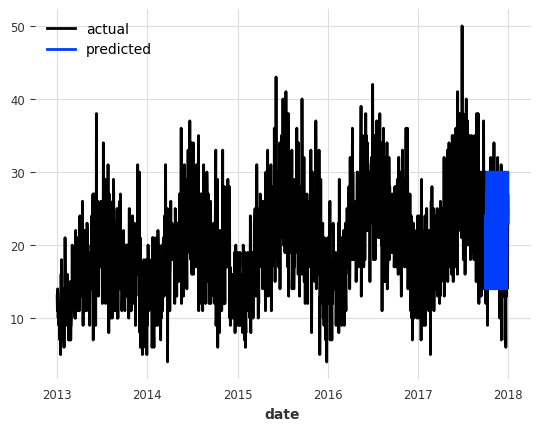

In [ ]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
naive_forecast = seasonal_model.predict(len(val))

time_df.plot(label='actual')
naive_forecast.plot(label='predicted')

In [ ]:
eval_forecast(seasonal_model,time_df, naive_forecast)

model NaiveSeasonal(K=7) obtains MAPE: 38.17%


Conclusion: The Naive Seasonal model performs poorly and does not account for the trend.

## NaieDrift

<Axes: xlabel='date'>

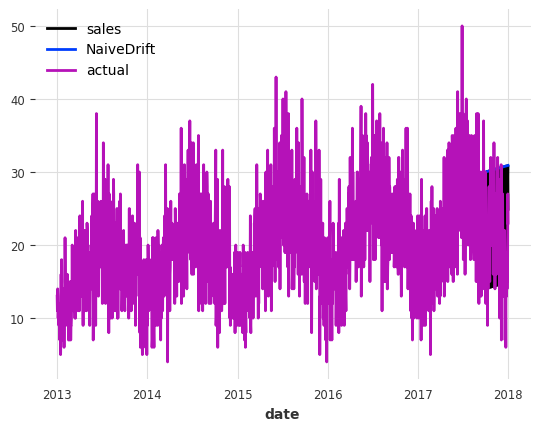

In [ ]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_preds = drift_model.predict(len(val))

combined = drift_preds+ naive_forecast - train.last_value()

combined.plot('combined')
drift_preds.plot(label='NaiveDrift')
time_df.plot(label='actual')

In [ ]:
eval_forecast(drift_model, time_df, combined)

model NaiveDrift() obtains MAPE: 39.91%


Conclusion: The Naive Drift model performs poorly, exhibiting a very high percentage of error.

## XBGModel

In [ ]:
def enrich_with_date_features(df):
  # Feature Extraction
  # df["hour"] = df['Month'].dt.hour
  # df["dayofweek"] = df['Month'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df

In [ ]:
##train_enriched = enrich_with_date_features(train.pd_dataframe().reset_index())
##val_enriched = enrich_with_date_features(val.pd_dataframe().reset_index())

In [ ]:
scaler = Scaler()
train_enriched = scaler.fit_transform(train)
val_enriched = scaler.transform(val)

In [ ]:
model_xgb = XGBModel(
    lags=7,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

model_xgb.fit(train_enriched)
pred = model_xgb.predict(len(val_enriched))
##pred.values()

<Axes: xlabel='date'>

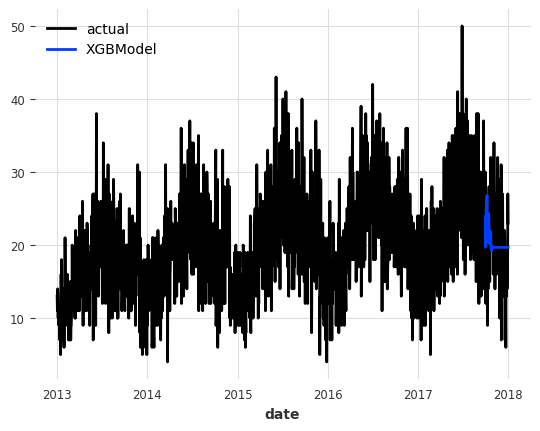

In [ ]:
forecast = scaler.inverse_transform(pred)

time_df.plot(label='actual')
forecast.plot(label='XGBModel')

In [ ]:
eval_forecast(model_xgb, forecast, val)

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 23.38%


Conclusion: XGBoost yields better results than naive models, but a 23% error is still quite high, indicating that XGBoost is not performing well.

## ExponentialSmoothing

In [ ]:
def plot_results(series, forecast):
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

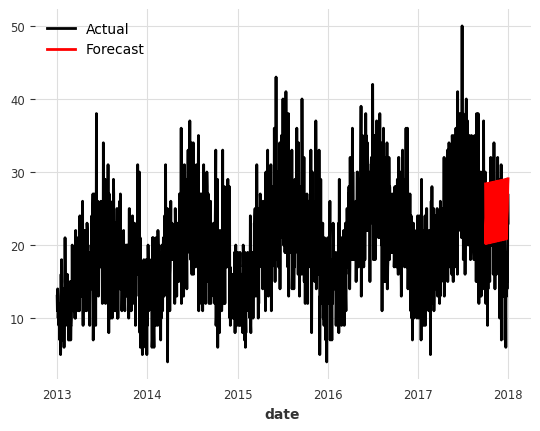

model ExponentialSmoothing() obtains MAPE: 39.01%


In [ ]:
model_exp = ExponentialSmoothing()
fit_and_plot(model_exp, time_df, train, val)

Conclusion: ExponentialSmoothing() yields poor results with a high error rate of 39%. However, this model does effectively account for the trend.



## ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



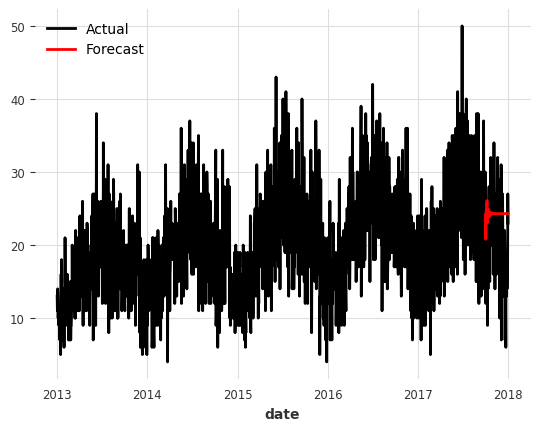

model ARIMA(p=7, q=1) obtains MAPE: 39.53%


In [ ]:
arima = ARIMA(p=7, d=1, q=1)
fit_and_plot(arima , time_df, train, val)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



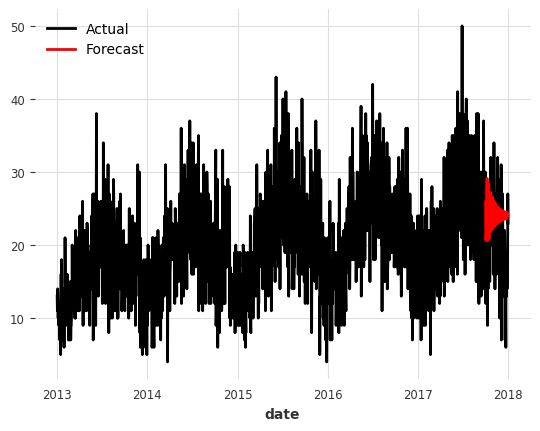

model ARIMA(p=21, q=1) obtains MAPE: 37.83%


In [ ]:
arima2 = ARIMA(p=21, d=1, q=1)
fit_and_plot(arima2 , time_df, train, val)

Conclusion: ARIMA performs poorly in forecasting the time series and has the highest error among all the models.

## AutoARIMA

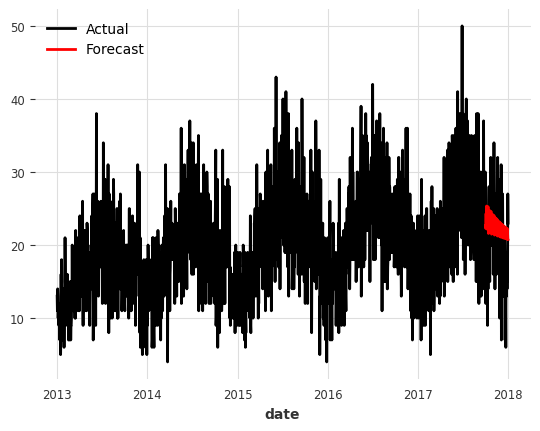

model AutoARIMA(start_p=2, max_p=16, start_q=1, max_q=5, d=0, seasonal=True, m=6) obtains MAPE: 33.30%


In [ ]:
model = AutoARIMA(
    start_p=2, max_p=16,
    start_q=1, max_q=5,
    d=0,
    seasonal=True, m=6
)

fit_and_plot(model, time_df, train, val)

## Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpayiqk_zf/6rm1i7k8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpayiqk_zf/0wb1np40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9289', 'data', 'file=/tmp/tmpayiqk_zf/6rm1i7k8.json', 'init=/tmp/tmpayiqk_zf/0wb1np40.json', 'output', 'file=/tmp/tmpayiqk_zf/prophet_model_ho541na/prophet_model-20241020114246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:42:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


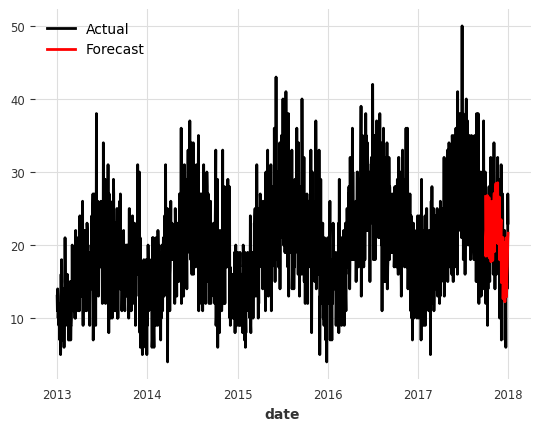

model Prophet() obtains MAPE: 23.80%


In [ ]:
prophet = Prophet()
fit_and_plot(prophet, time_df, train, val)

In [ ]:
prophet_preds = prophet.predict(len(val)).values()
actual_val = val.values()

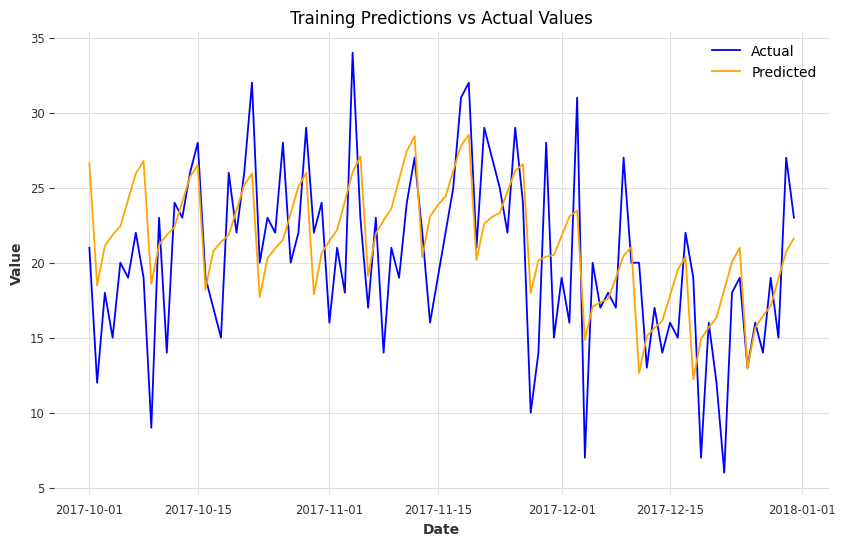

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val.time_index, actual_val, label='Actual', color='blue')
plt.plot(val.time_index, prophet_preds, label='Predicted', color='orange')
plt.title('Training Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


Conclusion: Prophet provides the best forecasts for the time series. However, a 23% error is still quite substantial, so I would further tune the model for improved results.

## RNNModel

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

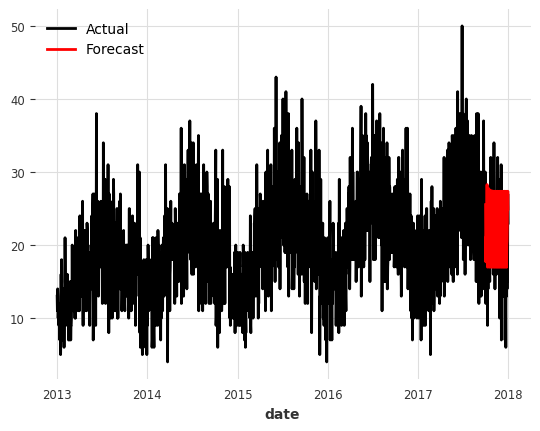

model RNNModel(model=LSTM, input_chunk_length=12, n_epochs=300) obtains MAPE: 31.73%


In [ ]:
rnnm = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
fit_and_plot(rnnm, time_df, train, val)

In [ ]:
rnnm_preds = rnnm.predict(len(val)).values()
actual_val = val.values()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

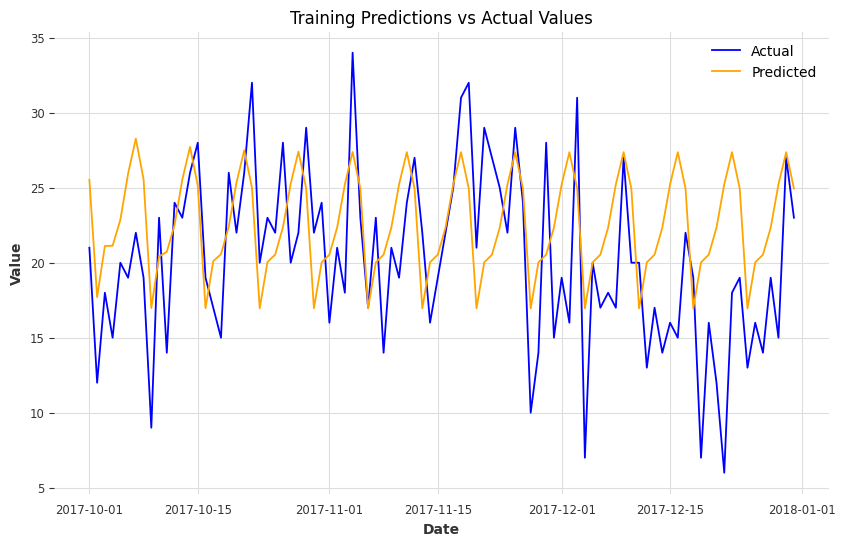

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val.time_index, actual_val, label='Actual', color='blue')
plt.plot(val.time_index, rnnm_preds, label='Predicted', color='orange')
plt.title('Training Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

Conclusion: RNN performs worse in forecasting the time series compared to Prophet, with a high error rate of 31%.

## BackTest

100%|██████████| 90/90 [00:04<00:00, 18.53it/s]


MAPE = 27.13%


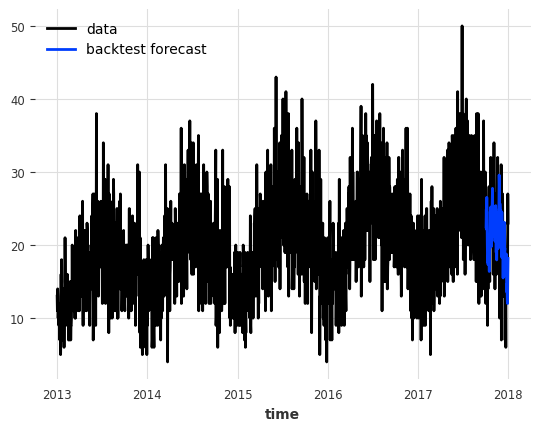

In [ ]:
## the best model XGBoost (model_xgb)
hfc_params = {
    "series": time_df,
    "start": pd.Timestamp("2017-10-01"),
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast = model_xgb.historical_forecasts(last_points_only=True, **hfc_params)

time_df.plot(label="data")
historical_fcast.plot(label="backtest forecast")
print(f"MAPE = {mape(time_df, historical_fcast):.2f}%")

MAPE = 27.13%


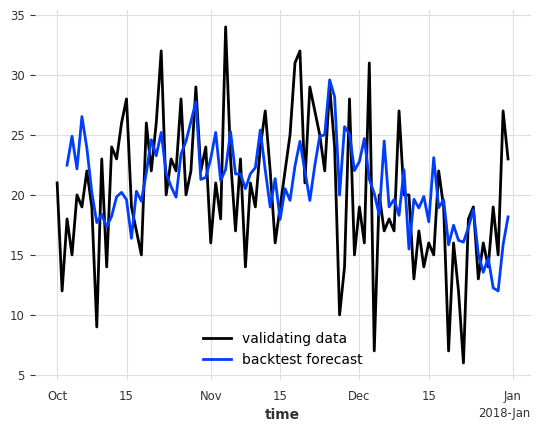

In [ ]:
val.plot(label="validating data")
historical_fcast.plot(label="backtest forecast")
print(f"MAPE = {mape(val, historical_fcast):.2f}%")

Conclusion: The accuracy on the backtest is worse than that of the model.

## Residual Analysis

100%|██████████| 1817/1817 [01:13<00:00, 24.58it/s]


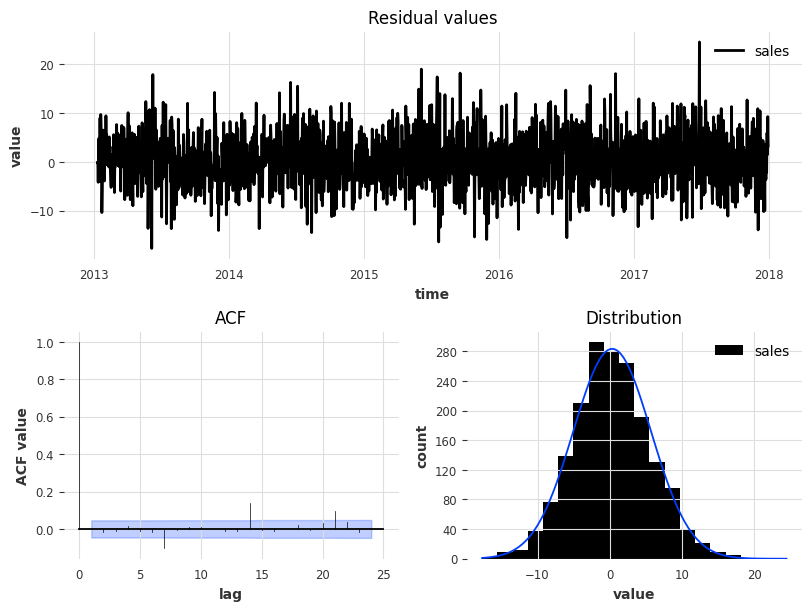

In [ ]:
plot_residuals_analysis(model_xgb.residuals(time_df, verbose=True))

Conclusion: We can see that the distribution is centered around 0, indicating that our model is unbiased. Additionally, we notice a significant ACF (autocorrelation function) value at lag 14, suggesting that the residuals contain information that was not utilized by the model.

Conclusion:

- I would train a separate model for each product in each store, resulting in a total of 500 models (50 products * 10 stores). This approach allows for capturing the specific characteristics of sales for each product in each store, which will improve the accuracy of the forecasts.

- I would use models like XGBoost or Prophet, as they have shown the best performance. Additionally, I would further tune each model to achieve better results and reduce the percentage of error. The residual analysis also indicates the presence of lags that contain information not accounted for by the model.